In [1]:
# Import libraries

# Usual libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import re
import string
import random

# NLTK
import nltk
from nltk.tokenize import regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Assigning variables
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
stop_words = stopwords.words('english')

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer

# Models
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import lightgbm as gbm
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

# Doc/Word Vectors
from gensim.models.fasttext import FastText
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

# LDA and LSI Models
from sklearn.decomposition import LatentDirichletAllocation as LDA
from gensim.models import LsiModel, CoherenceModel
from gensim.models import TfidfModel
from gensim.models import LdaModel, LdaMulticore
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# Spacy
import spacy
from spacy.lang.en.examples import sentences
from spacy import displacy
from spacytextblob.spacytextblob import SpacyTextBlob
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe('spacytextblob')
stopwords_nlp = nlp.Defaults.stop_words

# LIME and SHAP
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import shap

# Set seed
np.random.seed(123)

In [4]:
# Import datasets
df = pd.read_csv(r'C:\Users\Scott\Box\Shyam\01_Shyam_Personal\Text Mining\Twitter\IranUnrest_YoutubeFinalData.csv')
df.head()

,Name,Comment,Time,Likes,Reply Count
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0


## Data Cleaning

In [5]:
# Check for duplicates and drop them
print(len(df))
df.drop_duplicates(['Comment'])
print(len(df))

14988
14988


In [6]:
# Loop through the column and clean the data

new_text = []

for text in df['Comment']:
    text = re.sub(r'[!"#$%&()*+,-./:;<=>?[\]^_`{|}~]', ' ', text).lower()               # Remove punctuation and make the letters lowercase
        
    words = nltk.tokenize.word_tokenize(text)                                           # Tokenize the text
    words = [w for w in words if w.isalpha()]                                           # Ensure the data is alphabets (remove numbers)
    words = [w for w in words if len(w)>1 and w not in stopwords.words('english')]      # Remove words that are less than 2 characters and stop words as well
        
    words = [lemmatizer.lemmatize(w) for w in words]                                    # Lemmatize the words
    new_text.append(' '.join(words))

# Make a copy of the original dataframe and add the cleaned text into a new column
df['cleaned_tweet'] = new_text
df.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...


## EDA

In [7]:
# Count the number of likes a post has received
df['Likes'].value_counts().nlargest(10)

0.0     7736
1.0     1782
2.0      442
3.0      157
4.0      102
6.0       68
5.0       63
8.0       36
7.0       32
10.0      28
Name: Likes, dtype: int64

In [8]:
df['Reply Count'].value_counts().nlargest(10)

0.0    9591
1.0     726
2.0     203
3.0      96
4.0      45
7.0      24
6.0      24
5.0      22
9.0      18
8.0      12
Name: Reply Count, dtype: int64

## Sentiment Analysis

In [9]:
# Creating a copy of the dataframe
df_sentiment = df.copy()

In [10]:
df_sentiment['compound'] = df_sentiment['Comment'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df_sentiment['positive'] = df_sentiment['Comment'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['pos'])
df_sentiment['negative'] = df_sentiment['Comment'].apply(lambda x:SentimentIntensityAnalyzer().polarity_scores(x)['neg'])
df_sentiment.head()

,Name,Comment,Time,Likes,Reply Count,cleaned_tweet,compound,positive,negative
0,Guardian News,Iranian schoolgirl ‘beaten to death for refusi...,2022-10-19T09:42:51Z,8.0,2.0,iranian schoolgirl beaten death refusing sing ...,-0.7650,0.000,0.375
1,silent majority,One more reason why IS lam not compatible for...,2022-10-19T21:11:37Z,NaN,NaN,one reason lam compatible western democracy br...,0.5423,0.156,0.000
2,Good,Free Iran,2022-10-22T22:05:44Z,0.0,0.0,free iran,0.5106,0.767,0.000
3,Spencer Brown,"This abhorrent, evil, archaic regime is killin...",2022-10-22T16:33:27Z,0.0,0.0,abhorrent evil archaic regime killing woman sc...,-0.9601,0.000,0.634
4,sunita thind,I have no words. Grateful to have freedoms 🇬🇧h...,2022-10-22T08:54:14Z,1.0,0.0,word grateful freedom many beautiful innocent ...,0.7146,0.414,0.209


In [11]:
print('Compound:', df_sentiment['compound'].mean())
print('Positive:', df_sentiment['positive'].mean())
print('Negative:', df_sentiment['negative'].mean())

Compound: -0.012537630104083035
Positive: 0.1328261942887642
Negative: 0.12094462236455907


Text(0.5, 1.0, 'Polarity Score Distribution')

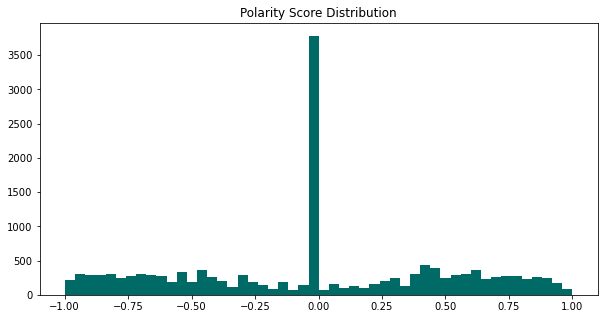

In [12]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['compound'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')

In [13]:
# Trying Spacy
# lets create a new column with the sentiment of the comment

df_sentiment['sentiment'] = df_sentiment['Comment'].apply(lambda x: nlp(x)._.blob.polarity)

In [14]:
print('Text Blob Polartiy Score:', df_sentiment['sentiment'].mean())

Text Blob Polartiy Score: 0.04845205622708246


Text(0.5, 1.0, 'Polarity Score Distribution')

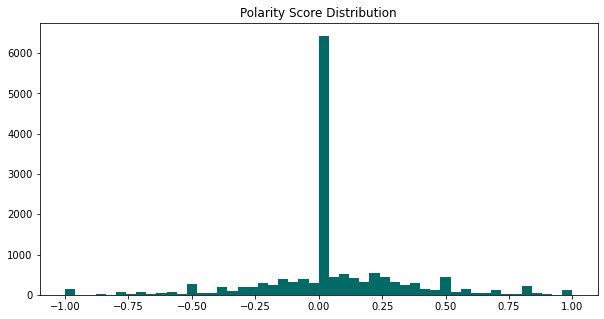

In [15]:
plt.figure(figsize=(10,5))
plt.hist(df_sentiment['sentiment'], bins = 50, color = '#006B66')
# plt.ylim(0,200)
plt.title('Polarity Score Distribution')